<a href="https://colab.research.google.com/github/Odigie43/-Binary-Classification-of-Pneumonia-Using-PneumoniaMNIST-Dataset-/blob/main/binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
keras.__version__

'2.15.0'

In [ ]:
# Built-in Imports
import random

In [ ]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
DATA_NAME = "PneumoniaMNIST"

In [ ]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2024-03-28 07:20:04--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py.2’

info.py.2           100%[===================>]  27.12K  --.-KB/s    in 0.009s  

2024-03-28 07:20:04 (3.03 MB/s) - ‘info.py.2’ saved [27766/27766]



In [ ]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of 28209eda62fecd6e6a2d98b1501bb15f so we will re-download the data.
4170669/4170669 [==============================] - 8s 2us/step


In [ ]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]

In [ ]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


1028: normal


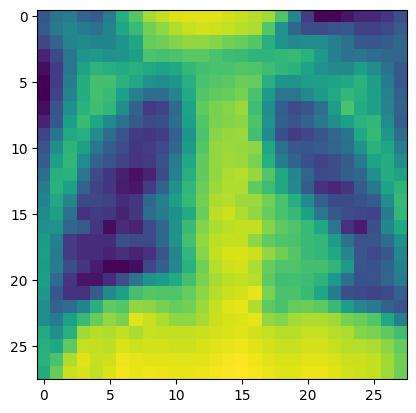

In [ ]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

In [ ]:
len(train_y)

4708

In [ ]:
len(test_y)

624

In [ ]:
len(val_y)

524

In [ ]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True,
                                    vertical_flip=True)

In [ ]:
import numpy as np

# Assuming train_x and val_x are your training and validation datasets
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2], 1)
val_x = val_x.reshape(val_x.shape[0], val_x.shape[1], val_x.shape[2], 1)

# Fit the data generator
data_generator.fit(np.append(train_x, val_x, axis=0))


In [ ]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(flatten)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 5, 5, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 800)               0     

In [ ]:
from tensorflow.keras import layers, Model
import numpy as np

# Define the input layer of the model with the size of an image.
input_layer = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer for feature extraction.
conv1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input_layer)
# Pooling layer to reduce dimensionality after the first convolutional layer.
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

# Defines the second convolutional layer for additional feature extraction.
conv2 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(pool1)
# Pooling layer to reduce dimensionality after the second convolutional layer.
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

# Flatten the outputs of the convolutional layers into a one-dimensional array.
flatten = layers.Flatten()(pool2)

# Defines the output layer of the model for classification.
# For binary classification, use a single output unit and sigmoid activation.
output_layer = layers.Dense(units=1, activation="sigmoid")(flatten)

# Initialize the defined model and print a summary of the model.
model = Model(inputs=input_layer, outputs=output_layer, name="Binary_Classification_Model")
model.summary()


Model: "Binary_Classification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 5, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 160

In [ ]:
# Defines the parameters used during training.
BATCH_SIZE = 32  # Reducing batch size from 64 to 32 for better generalization
NUM_EPOCHS = 20  # Increasing the number of epochs from 10  to 20 to  allow for more training iterations
LEARNING_RATE = 0.001  # Keeping the learning rate as 0.001 (adjust as needed)

# Additional Regularization and Optimization Techniques
DROPOUT_RATE = 0.25  # Incorporating dropout regularization with a dropout rate of 0.25
WEIGHT_DECAY = 1e-4  # Introducing weight decay (L2 regularization) with a coefficient of 1e-4

# Data Augmentation Parameters
# Define parameters for data augmentation such as rotation, width and height shifts, zoom range, etc.
DATA_AUGMENTATION = True  # Enable data augmentation
ROTATION_RANGE = 20  # Range for random rotations
WIDTH_SHIFT_RANGE = 0.1  # Fraction of total width for random horizontal shifts
HEIGHT_SHIFT_RANGE = 0.1  # Fraction of total height for random vertical shifts
ZOOM_RANGE = 0.2  # Range for random zoom
HORIZONTAL_FLIP = True  # Allow horizontal flipping of images

# Define the parameters used during training.
TRAINING_PARAMETERS = {
    "BATCH_SIZE": BATCH_SIZE,
    "NUM_EPOCHS": NUM_EPOCHS,
    "LEARNING_RATE": LEARNING_RATE,
    "DROPOUT_RATE": DROPOUT_RATE,
    "WEIGHT_DECAY": WEIGHT_DECAY,
    "DATA_AUGMENTATION": DATA_AUGMENTATION,
    "ROTATION_RANGE": ROTATION_RANGE,
    "WIDTH_SHIFT_RANGE": WIDTH_SHIFT_RANGE,
    "HEIGHT_SHIFT_RANGE": HEIGHT_SHIFT_RANGE,
    "ZOOM_RANGE": ZOOM_RANGE,
    "HORIZONTAL_FLIP": HORIZONTAL_FLIP
}

# Print the updated training parameters
print("Updated Training Parameters:")
for key, value in TRAINING_PARAMETERS.items():
    print(f"{key}: {value}")


Updated Training Parameters:
BATCH_SIZE: 32
NUM_EPOCHS: 20
LEARNING_RATE: 0.001
DROPOUT_RATE: 0.25
WEIGHT_DECAY: 0.0001
DATA_AUGMENTATION: True
ROTATION_RANGE: 20
WIDTH_SHIFT_RANGE: 0.1
HEIGHT_SHIFT_RANGE: 0.1
ZOOM_RANGE: 0.2
HORIZONTAL_FLIP: True


In [ ]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
from tensorflow.keras.optimizers import SGD

optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])


In [ ]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/20
147/147 [==============================] - 6s 37ms/step - loss: 0.6949 - accuracy: 0.5000 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 2/20
147/147 [==============================] - 4s 28ms/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 3/20
147/147 [==============================] - 4s 30ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 4/20
147/147 [==============================] - 4s 28ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 5/20
147/147 [==============================] - 5s 34ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 6/20
147/147 [==============================] - 4s 27ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 7/20
147/147 [==============================] - 5s 31ms/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.6939 - val_accuracy: 0.5000

To train the model, batches of training and validation data are passed through data generators in this code above. Based on batch and dataset sizes, it indicates the number of steps per epoch and validation steps. An agreed-upon number of epochs is used for the training procedure.

The time required for each training step is shown below as 4s 28ms/step. Each step took about 4 seconds and 28 milliseconds in this instance. In training, a step is the model's processing of a single batch of data.


loss: 0.6936: This is the value of the loss function that was determined throughout the training procedure using the training dataset. The loss function calculates the degree to which the actual target values and the model's predictions agree. This instance has a loss value of around 0.6936.


accuracy: 0.5000: This shows how accurate the model was using the training set of data. The accuracy is the percentage of correctly categorised samples in the training dataset relative to the total number of samples. In this case, half of the training samples have an accuracy of 50%.


The value of the loss function that was determined during the training phase using the validation dataset is indicated by the value val_loss: 0.6936. How well the model performs on unobserved data is tracked using the validation loss. A validation loss value of roughly 0.6936 is found in this instance.


Val_accuracy = 0.5000: On the validation dataset, this shows how accurate the model is. Similar to the training accuracy, the validation accuracy shows the percentage of samples in the validation dataset that are properly identified out of all the samples. This instance also has a 50% validation accuracy.


In conclusion, this output indicates that throughout training, there is little to no change in accuracy and loss over epochs for both training and validation. This could mean that there are problems with the model's architecture, like a basic model, or not enough training data, which are preventing the model from learning efficiently.

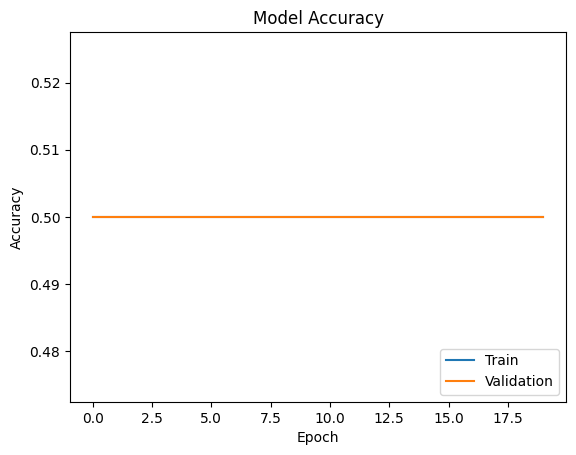

In [ ]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

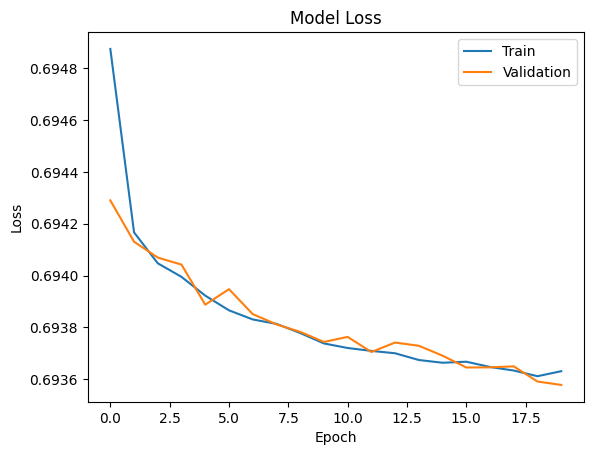

In [ ]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()